In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import classification_report, make_scorer, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import KFold, train_test_split, cross_validate, RepeatedStratifiedKFold, GridSearchCV, cross_val_score
import numpy as np
from imblearn.combine import SMOTETomek, SMOTEENN
from collections import Counter
from imblearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
import seaborn as sns
import sys
sys.path.append('/Users/ayoucruz/Desktop/Data_Science/3nd_Semester/DATA7901 Capstone project/Capstone/Models/Functions')
from Evaluation import *
from Preparation import *
import pickle

In [2]:
X, y, data = preparation_class_threshold()

/Users/ayoucruz/Desktop/Data_Science/3nd_Semester/DATA7901 Capstone project/Capstone/Models/Functions/Preparation.py:711: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df_location = pd.read_csv('../../Dataset/Location.csv')


In [3]:
weather_features = ['Crash_Road_Surface_Condition_Sealed - Dry','Crash_Road_Surface_Condition_Sealed - Wet', 
                    'Crash_Road_Surface_Condition_Unsealed - Dry','Crash_Road_Surface_Condition_Unsealed - Wet', 
                    'Crash_Atmospheric_Condition_Clear', 'Crash_Atmospheric_Condition_Fog','Crash_Atmospheric_Condition_Raining',
                    'Crash_Atmospheric_Condition_Smoke/Dust', 'Crash_Lighting_Condition_Darkness - Lighted',
                    'Crash_Lighting_Condition_Darkness - Not lighted','Crash_Lighting_Condition_Dawn/Dusk','Crash_Lighting_Condition_Daylight',
                    'Crash_Road_Horiz_Align_Curved - view obscured','Crash_Road_Horiz_Align_Curved - view open','Crash_Road_Horiz_Align_Straight', 
                    'Crash_Road_Vert_Align_Crest', 'Crash_Road_Vert_Align_Dip', 'Crash_Road_Vert_Align_Grade','Crash_Road_Vert_Align_Level']

new_features =['Crash_Speed_Limit_100 - 110 km/h', 'Crash_Speed_Limit_60 km/h', 'Crash_Speed_Limit_80 - 90 km/h','Crash_Roadway_Feature_No Roadway Feature',
               'Crash_Speed_Limit_0 - 50 km/h','Crash_Traffic_Control_No traffic control','Crash_Nature_Hit object', 'Crash_Nature_Fall from vehicle',
               'Crash_Controlling_Authority_Locally-controlled', 'Crash_Nature_Rear-end','Crash_Nature_Angle','Crash_Month_Q2','Crash_Nature_Hit pedestrian']
X = X[weather_features + new_features]

### MLP Architecture

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.hidden1 = nn.Linear(32, 128)
        self.dropout1 = nn.Dropout(0.5)  # Moderate dropout rate
        self.hidden2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.5)
        self.output = nn.Linear(64, 4)

    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = self.dropout1(x)
        x = F.relu(self.hidden2(x))
        x = self.dropout2(x)
        x = self.output(x)
        return x

### Train test split with baseline

In [45]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

### Training function

In [46]:
def train_and_validate(model, train_loader, val_loader, optimizer, criterion, num_epochs):
    training_losses = []
    valid_losses = []
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for inputs, labels in tqdm(train_loader):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
        training_loss = train_loss / len(train_loader.dataset)
        training_losses.append(training_loss)
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
        validation_loss = val_loss / len(val_loader.dataset)
        valid_losses.append(validation_loss)
        print(f'Epoch {epoch + 1}, Training Loss: {training_loss}, Validation Loss: {validation_loss}')
    return training_losses, valid_losses

### Evaluation function

In [47]:
def evaluate_model(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_pred.extend(predicted.numpy())
            y_true.extend(labels.numpy())

    evaluation_class_8_MLP(y_true, y_pred)

### SMOTE

In [48]:
X_tensor = torch.tensor(X.values, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

X_train_val, X_test, y_train_val, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)
y_smote_tensor = torch.tensor(y_smote, dtype=torch.long)
X_smote_tensor = torch.tensor(X_smote, dtype=torch.float32)

In [62]:
train_data = TensorDataset(X_smote_tensor, y_smote_tensor)
val_data = TensorDataset(X_val, y_val)
test_data = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=512, shuffle=True)
val_loader = DataLoader(val_data, batch_size=512, shuffle=False)
test_loader = DataLoader(test_data, batch_size=512, shuffle=False)

100%|██████████| 1101/1101 [00:02<00:00, 383.36it/s]


Epoch 1, Training Loss: 1.4195967643360667, Validation Loss: 1.41672436355678


100%|██████████| 1101/1101 [00:02<00:00, 392.03it/s]


Epoch 2, Training Loss: 1.4156873556638927, Validation Loss: 1.412826341697643


100%|██████████| 1101/1101 [00:02<00:00, 376.63it/s]


Epoch 3, Training Loss: 1.4122277633257265, Validation Loss: 1.4094059853587426


100%|██████████| 1101/1101 [00:02<00:00, 380.58it/s]


Epoch 4, Training Loss: 1.4084334392732543, Validation Loss: 1.4062325559877489


100%|██████████| 1101/1101 [00:02<00:00, 386.90it/s]


Epoch 5, Training Loss: 1.4057073837914522, Validation Loss: 1.4033540004449738


100%|██████████| 1101/1101 [00:02<00:00, 370.19it/s]


Epoch 6, Training Loss: 1.4031003637251025, Validation Loss: 1.4007564140775113


100%|██████████| 1101/1101 [00:02<00:00, 380.72it/s]


Epoch 7, Training Loss: 1.3993316776034055, Validation Loss: 1.3984066987331507


100%|██████████| 1101/1101 [00:02<00:00, 388.37it/s]


Epoch 8, Training Loss: 1.3975675655607436, Validation Loss: 1.3962398561903413


100%|██████████| 1101/1101 [00:02<00:00, 388.08it/s]


Epoch 9, Training Loss: 1.395197745123733, Validation Loss: 1.3943038267292138


100%|██████████| 1101/1101 [00:02<00:00, 398.00it/s]


Epoch 10, Training Loss: 1.3927838950312723, Validation Loss: 1.392499599983704


100%|██████████| 1101/1101 [00:02<00:00, 376.35it/s]


Epoch 11, Training Loss: 1.3906029102048931, Validation Loss: 1.3907592677472327


100%|██████████| 1101/1101 [00:02<00:00, 393.10it/s]


Epoch 12, Training Loss: 1.3884852804062278, Validation Loss: 1.3891796500391747


100%|██████████| 1101/1101 [00:02<00:00, 387.61it/s]


Epoch 13, Training Loss: 1.3861036624769272, Validation Loss: 1.3877681430720008


100%|██████████| 1101/1101 [00:02<00:00, 390.44it/s]


Epoch 14, Training Loss: 1.384439756904725, Validation Loss: 1.3864679527674513


100%|██████████| 1101/1101 [00:02<00:00, 384.30it/s]


Epoch 15, Training Loss: 1.3827144755966765, Validation Loss: 1.3852058348434184


100%|██████████| 1101/1101 [00:02<00:00, 399.56it/s]


Epoch 16, Training Loss: 1.3806100783236122, Validation Loss: 1.3840235161678338


100%|██████████| 1101/1101 [00:02<00:00, 383.50it/s]


Epoch 17, Training Loss: 1.379005966494252, Validation Loss: 1.382917129301515


100%|██████████| 1101/1101 [00:02<00:00, 404.05it/s]


Epoch 18, Training Loss: 1.3775221854545625, Validation Loss: 1.3818801477210836


100%|██████████| 1101/1101 [00:02<00:00, 406.13it/s]


Epoch 19, Training Loss: 1.3758415354837845, Validation Loss: 1.3808905835223502


100%|██████████| 1101/1101 [00:02<00:00, 379.10it/s]


Epoch 20, Training Loss: 1.3739877316320928, Validation Loss: 1.3800044157577116


100%|██████████| 1101/1101 [00:02<00:00, 406.09it/s]


Epoch 21, Training Loss: 1.3724872663180097, Validation Loss: 1.3791040728997095


100%|██████████| 1101/1101 [00:02<00:00, 380.18it/s]


Epoch 22, Training Loss: 1.3709520466103402, Validation Loss: 1.3781985261851413


100%|██████████| 1101/1101 [00:02<00:00, 401.57it/s]


Epoch 23, Training Loss: 1.369853550150171, Validation Loss: 1.377377919096923


100%|██████████| 1101/1101 [00:02<00:00, 403.92it/s]


Epoch 24, Training Loss: 1.3679741625248216, Validation Loss: 1.3765975429275121


100%|██████████| 1101/1101 [00:02<00:00, 383.17it/s]


Epoch 25, Training Loss: 1.3668638589668443, Validation Loss: 1.3757590613023105


100%|██████████| 1101/1101 [00:02<00:00, 387.15it/s]


Epoch 26, Training Loss: 1.3654226004706747, Validation Loss: 1.374941434823059


100%|██████████| 1101/1101 [00:02<00:00, 384.03it/s]


Epoch 27, Training Loss: 1.363575164339841, Validation Loss: 1.3741291470438741


100%|██████████| 1101/1101 [00:02<00:00, 391.37it/s]


Epoch 28, Training Loss: 1.3622687721485303, Validation Loss: 1.3733567621036586


100%|██████████| 1101/1101 [00:03<00:00, 365.49it/s]


Epoch 29, Training Loss: 1.360723590678892, Validation Loss: 1.3725533780265027


100%|██████████| 1101/1101 [00:02<00:00, 394.94it/s]


Epoch 30, Training Loss: 1.3593863215114375, Validation Loss: 1.3718138132258084
Accuracy:  0.3004977351732856
Precision:  0.47890850963012543
Recall:  0.3004977351732856
F1-Score:  0.3531377363675725
--------------------------------------------
                 precision    recall  f1-score   support

          Fatal       0.04      0.67      0.07      1197
   Minor injury       0.19      0.21      0.20     10365
Property damage       0.27      0.28      0.27     17428
 Serious injury       0.63      0.32      0.42     46954

       accuracy                           0.30     75944
      macro avg       0.28      0.37      0.24     75944
   weighted avg       0.48      0.30      0.35     75944



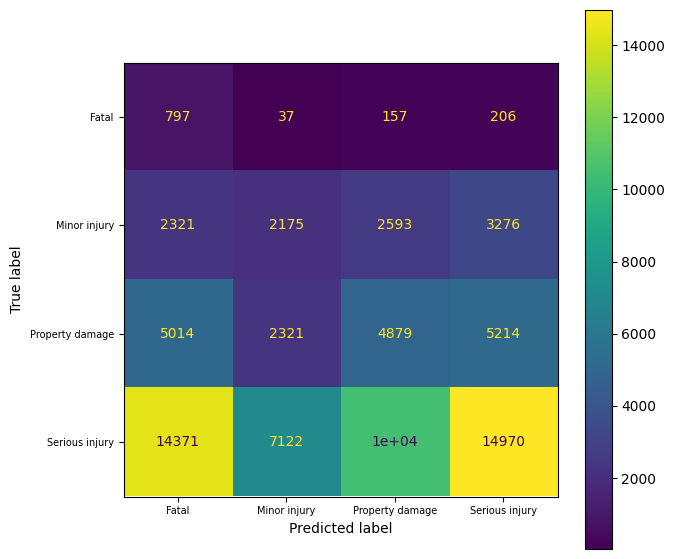

In [63]:
model = MLP()
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.0001)
optimizer = optim.Adam(model.parameters(), lr=0.000001)

training_losses, valid_losses = train_and_validate(model, train_loader, val_loader, optimizer, criterion, num_epochs=30)

evaluate_model(model, test_loader)

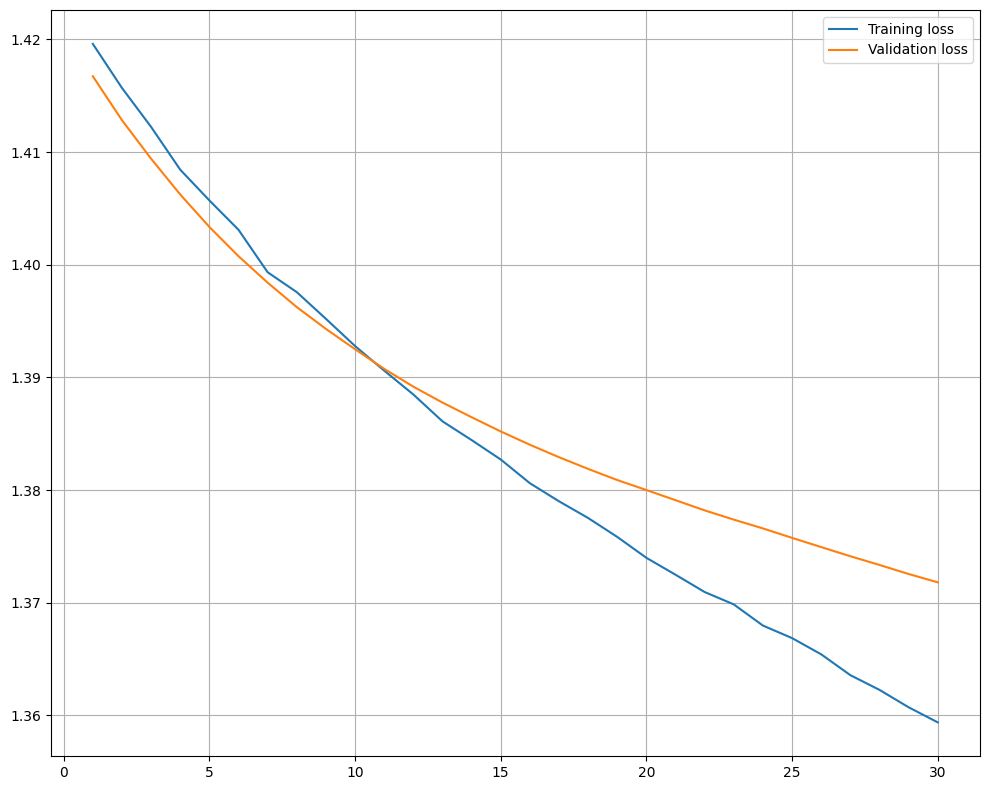

In [64]:
epochs = np.arange(1,31)
plt.figure(figsize=(10, 8))
plt.plot(epochs, training_losses, label="Training loss")
plt.plot(epochs, valid_losses, label="Validation loss")
plt.tight_layout()
plt.legend()
plt.grid()
plt.show()